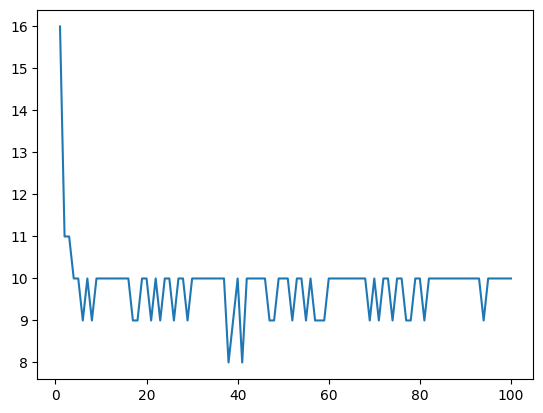

In [258]:
import networkx as nx
import random as rd

"""G = nx.Graph()
G.add_nodes_from((0,1,2,3,4))
G.add_edges_from([(0,1),(1,2),(2,3),(3,4),(4,0),(0,2),(0,3),(1,3),(1,4),(2,4)])
"""
G = nx.random_regular_graph(10,100)

dic = nx.convert.to_dict_of_dicts(G)
sordic = sorted(dic.keys())
amatrix = {}
for i in sordic:
    amatrix.update({i:dic[i]})

# Tempo
dynp_tmax = 100

# taxa de infecção
beta = 4

# Condições iniciais
size = np.size(list(amatrix)) # Número de vértices

dyn_VI = np.zeros(size, int)           # lista de infectados com indices 'dyn_NI'
dyn_sig = np.zeros(size, int)          # Lista com as informações dos compartimentos S = 0, I = 1
avg_rho = np.zeros(dynp_tmax, np.float64)   # DLista da densidade de infecção no tempo t
avg_t = np.zeros(dynp_tmax, np.float64)     # Lista de tempo

dynp_pINI = 0.2 # Fração inicial de i0
dyn_sig[:] = 0.0 # Compartimentos: S = 0, I = 1
dyn_VI[:] = 0.0  # Lista de índices 'dyn_NI' com cada um direcionando a um vértice infectado.

dyn_NI = 0       # Número de infectados na dinâmica (usado como lista de índice)
dyn_Nk = 0       # Número de arestas conectadas aos infectados

# k_max é o maior número de arestas que um vértice pode ter.
k_max = 0
for chave, valor in amatrix.items():
    if len(valor) > k_max:
        k_max = len(valor)
        

# Infectados iniciais: i0
for i in range(0, int(size*dynp_pINI)): # dynp_pINI é uma fração e size é o número de vértices totais
    while True:

       # Sorteia um vertice aleatório
        ver = np.random.randint(0,size)


        # Se ele for suscetível: S = 0
        if dyn_sig[ver] == 0:

           # Adiciona na lista de infectados o vértice 'ver' no índice 'dyn_NI'
           dyn_VI[dyn_NI] = ver 

           # Aumenta o número de infectados
           dyn_NI += 1 

           # Muda de S = 0 para I = 0
           dyn_sig[ver] = 1 

           # Aumenta número total de arestas conectadas aos infectados.
           dyn_Nk += np.size(list(amatrix[ver]))

           break
        

# Dinâmica

dyn_t = 0
dyn_dt = 0.0
dyn_dt_pos = 1

while dyn_t <= dynp_tmax and dyn_NI > 0:
    

    # dyn_R: Taxa total
    # 1.0*dyn_NI: taxa total de recuperação. Gamma = 1.0 e dyn_NI é o número de infectados.
    # beta*dyn_Nk: taxa total de infecção. Beta taxa de infecção, dyn_NI é o número de arestas de todos os infectados.
    dyn_R = (1.0*dyn_NI + 1.0*beta*dyn_Nk)
               
    # Penso ser o 1.0 multiplicando apenas para o resultado ser um número flutuante e evitar problemas.
               
    # Probabilidade de se recuperar
    dyn_m = 1.0*dyn_NI/dyn_R
    
    # Atualizando o tempo
    rnd = max(np.random.uniform(),1e-12) # evitar u = 0
    dyn_dt = -np.log(rnd)/dyn_R 
    dyn_t += dyn_dt
    
    # Processo de recuperação
    if np.random.uniform() < dyn_m:

        # Seciono um vértice aleatório dentro dos índices 'dyn_NI'
        pos_inf = np.random.randint(0,dyn_NI)
        
        # Procuro dentro da lista 'dyn_VI' no índice 'pos_inf' o vértice infectado 'ver'.
        ver = dyn_VI[pos_inf]

        # Recupero ele.
        
        # Mudo de I = 1 para S = 0
        dyn_sig[ver] = 0
               
        # Reduzo o número de arestas conectadas aos infectados
        dyn_Nk -= np.size(list(amatrix[ver]))
               
        # Diminúi o número de infectados
        dyn_NI -= 1
               
        # Muda de lugar o último termo da lista de infectados 'dyn_VI' 
            # para o índice do vértice que acabou de ser recuperado. Diminuindo a lista em 1.
        dyn_VI[pos_inf] = dyn_VI[dyn_NI]
        
        # Processo de infecção
    else:
               
        # Selecionando um vértice i com a probabilidade ki/kmáx (arestas_de_i/aresta_máxima_da_rede)
        while True:
            pos_inf = np.random.randint(0,dyn_NI)
            ver = dyn_VI[pos_inf]
               
            # Número de arestas k de ver
            k = np.size(list(amatrix[ver]))
            
            # Probabilidade de ser escolhido: k/k_max.
            if np.random.uniform() < 1.0*k / (1.0*k_max):
                break

        # Selecionando um de seus vizinhos
        ver = np.random.choice(list(amatrix[1]))

        # Se o vizinho selecionado for suscetível, haverá uma infecção.
        if dyn_sig[ver] == 0:

            # Mudando de S para I
            dyn_sig[ver] = 1
                        
            # Aumentando o número de arestas conectadas aos infectados.
            dyn_Nk += np.size(list(amatrix[ver])) 
                        
            # Aumentando um elemento da lista
            dyn_VI[dyn_NI] = ver    
                        
            # Aumentando em 1 a lista
            dyn_NI += 1
            
        #print(dyn_NI)
        #print(dyn_t)

        # Salvando a dinamica por unidade de tempo
        while (dyn_t >= dyn_dt_pos): # Save data
            avg_rho[dyn_dt_pos - 1] += dyn_NI #1.0*dyn_NI/size
            avg_t[dyn_dt_pos - 1] += dyn_t
            dyn_dt_pos += 1
                        
import matplotlib.pyplot as plt
X = [i for i in avg_t if i != 0]
Y = [i for i in avg_rho if i != 0]
plt.plot(X,Y)